# Capacity allocation

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [3]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [4]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                     4
RU3                    10
RU1                     6
RU4                     5
Total                  25


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  25


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


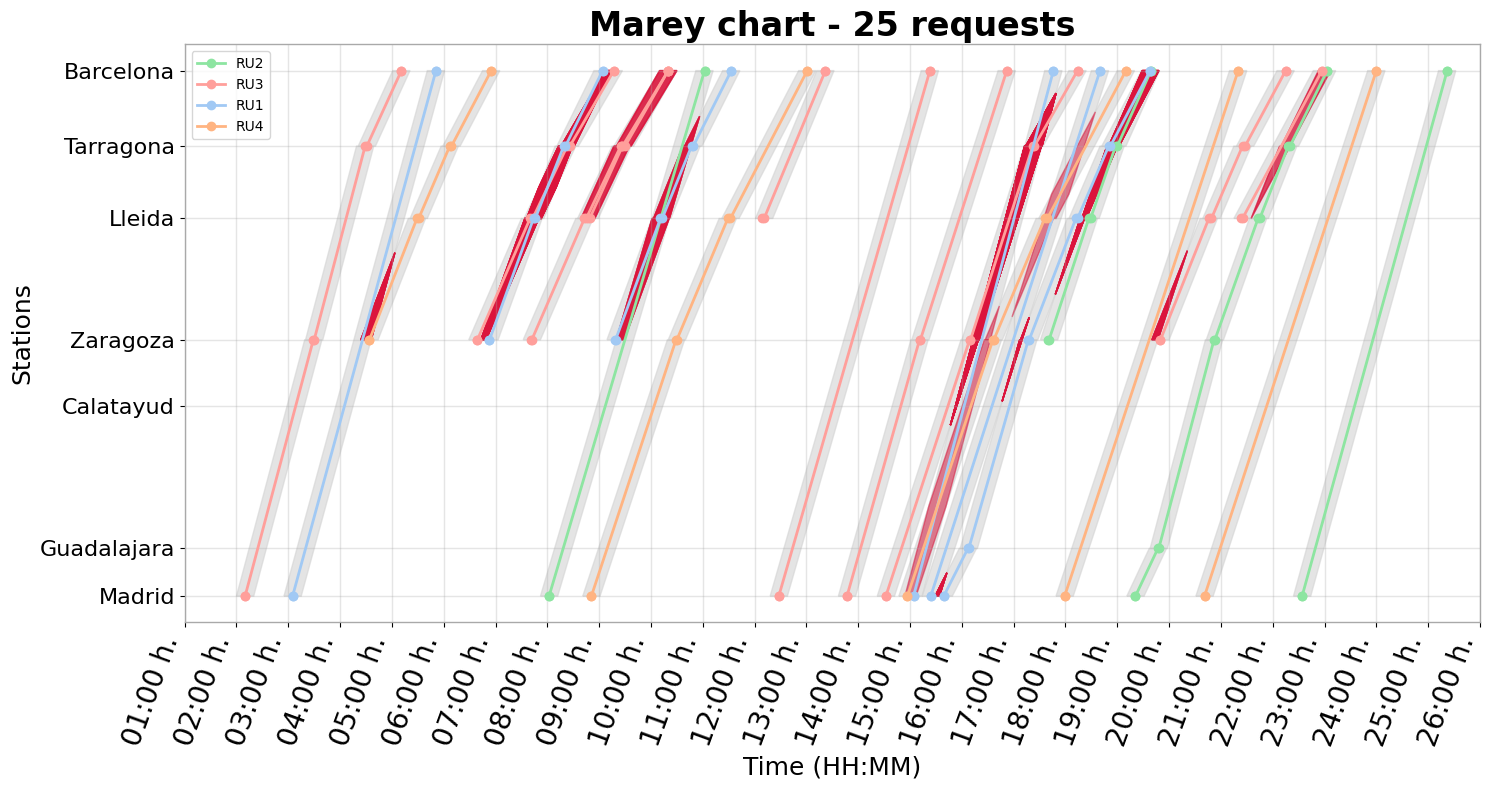

In [7]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [8]:
from src.timetabling_problem import MPTT

mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

In [9]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {"Genetic Algorithm": GA.BaseGA,
            "Particle Swarm Optimization": PSO.OriginalPSO,
            "Simulated Annealing": SA.OriginalSA,
            "Differential Evolution": DE.OriginalDE,
            "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
            "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
            "Artificial Bee Colony": ABC.OriginalABC,
            "Grey Wolf Optimizer": GWO.OriginalGWO,
            "Whale Optimization Algorithm": WOA.OriginalWOA,
            "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA}

In [13]:
from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

# 0. Problem formulation
lb, ub = zip(*mptt.boundaries.real)

problem = {"obj_func": mptt.objective_function,
           "bounds": IntegerVar(lb=lb,
                              ub=ub),
           "minmax": "max",
           "save_population": True}

# 1. Iter algorithms
df_history = pd.DataFrame()
df_population = pd.DataFrame()

for algo_name, algo in mp_algos.items():
    
    # Re-initialize seed
    np.random.seed(seed_initializer)
    
    print(f"Running {algo_name}")
    for r in range(1, runs+1):
        print("\tRun: ", r)
        
        run_seed = np.random.randint(0, 1000)
        
        # Run algorithm
        if algo_name == "Simulated Annealing":
            optimizer = algo(epoch=epochs*pop_size)
            optimizer.solve(problem, seed=run_seed)
        else:
            optimizer = algo(epoch=epochs, pop_size=pop_size)
            optimizer.solve(problem, seed=run_seed)
            
        # Build run history dataframe
        columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real', 
                   'Diversity', 'Exploitation', 'Exploration']
        run_history = pd.DataFrame(columns=columns)
        
        # Save optimizer history to dataframe
        for i, data in enumerate(optimizer.history.list_global_best):
            mptt.update_schedule(data.solution)
            run_history.loc[i] = [algo_name,
                                  i, 
                                  data.target.fitness,
                                  optimizer.history.list_epoch_time[i],
                                  mptt.get_heuristic_schedule(),
                                  data.solution,
                                  optimizer.history.list_diversity[i],
                                  optimizer.history.list_exploitation[i],
                                  optimizer.history.list_exploration[i]]
    
        run_history.insert(0, "Run", r)
        df_history = pd.concat([df_history, run_history], axis=0)
        
        # Population dataframe
        if algo_name == "Simulated Annealing":
            continue
        
        population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
        population_colums.insert(0, 'Iteration')
        run_population = pd.DataFrame(columns=population_colums)
        
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_row = [i]
            real = []
            discrete = [] 
            for individual in pop_epoch:
                mptt.update_schedule(individual.solution)
                real.append(individual.solution)
                discrete.append(mptt.get_heuristic_schedule())
            
            population_row = [i, *real, *discrete]
            run_population.loc[len(run_population)] = population_row
        
        run_population.insert(0, "Run", r)
        run_population.insert(1, "Algo", algo_name)
        df_population = pd.concat([df_population, run_population], axis=0)    

2024/12/02 01:03:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2024/12/02 01:03:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2459.8784050540485, Global best: 2459.8784050540485, Runtime: 0.24646 seconds
2024/12/02 01:03:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2460.3083388679565, Global best: 2460.3083388679565, Runtime: 0.24345 seconds
2024/12/02 01:03:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2574.4870272813346, Global best: 2574.4870272813346, Runtime: 0.24327 seconds
2024/12/02 01:03:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2926.5289315927625, Global best: 2926.5289315927625, Runtime: 0.23971 seconds
2024/12/02 01:03:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3015.8547096467346, Global best: 3015.8547096467346, Runtime: 0.23939 seconds
2024/12/02 01:03:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run:  2


2024/12/02 01:04:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2304.4293719715174, Global best: 2304.4293719715174, Runtime: 0.28471 seconds
2024/12/02 01:04:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2703.2164023021796, Global best: 2703.2164023021796, Runtime: 0.26215 seconds
2024/12/02 01:04:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2850.256580697497, Global best: 2850.256580697497, Runtime: 0.25057 seconds
2024/12/02 01:04:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2938.166609146115, Global best: 2938.166609146115, Runtime: 0.25032 seconds
2024/12/02 01:04:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2941.574784953517, Global best: 2941.574784953517, Runtime: 0.24689 seconds
2024/12/02 01:04:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run:  3


2024/12/02 01:04:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2607.780704168451, Global best: 2607.780704168451, Runtime: 0.25641 seconds
2024/12/02 01:04:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2586.0914566610863, Global best: 2607.780704168451, Runtime: 0.25691 seconds
2024/12/02 01:04:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2841.9490524677167, Global best: 2841.9490524677167, Runtime: 0.25197 seconds
2024/12/02 01:04:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3103.973183542429, Global best: 3103.973183542429, Runtime: 0.25546 seconds
2024/12/02 01:04:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3220.667590931876, Global best: 3220.667590931876, Runtime: 0.24950 seconds
2024/12/02 01:04:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch

	Run:  4


2024/12/02 01:05:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2305.7625909034273, Global best: 2305.7625909034273, Runtime: 0.24566 seconds
2024/12/02 01:05:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2265.9579898337533, Global best: 2305.7625909034273, Runtime: 0.24727 seconds
2024/12/02 01:05:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2489.4168053640346, Global best: 2489.4168053640346, Runtime: 0.25049 seconds
2024/12/02 01:05:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2499.328182244172, Global best: 2499.328182244172, Runtime: 0.24547 seconds
2024/12/02 01:05:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2777.6650302253165, Global best: 2777.6650302253165, Runtime: 0.24771 seconds
2024/12/02 01:05:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run:  5


2024/12/02 01:06:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2235.703801322386, Global best: 2238.717280544181, Runtime: 0.25186 seconds
2024/12/02 01:06:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2550.9501691093637, Global best: 2550.9501691093637, Runtime: 0.24879 seconds
2024/12/02 01:06:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2911.444314465418, Global best: 2911.444314465418, Runtime: 0.25240 seconds
2024/12/02 01:06:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2987.1810718577226, Global best: 2987.1810718577226, Runtime: 0.25152 seconds
2024/12/02 01:06:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3203.734952946348, Global best: 3203.734952946348, Runtime: 0.25368 seconds
2024/12/02 01:06:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

Running Particle Swarm Optimization
	Run:  1


2024/12/02 01:07:13 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2305.8744081819964, Global best: 2305.8744081819964, Runtime: 0.24423 seconds
2024/12/02 01:07:13 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2305.8744081819964, Global best: 2305.8744081819964, Runtime: 0.25801 seconds
2024/12/02 01:07:13 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2496.7934415210634, Global best: 2496.7934415210634, Runtime: 0.24839 seconds
2024/12/02 01:07:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2496.7934415210634, Global best: 2496.7934415210634, Runtime: 0.28542 seconds
2024/12/02 01:07:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2517.427278381763, Global best: 2517.427278381763, Runtime: 0.27115 seconds
2024/12/02 01:07:14 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch:

	Run:  2


2024/12/02 01:08:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2325.83547093849, Global best: 2325.83547093849, Runtime: 0.24401 seconds
2024/12/02 01:08:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2580.493913082158, Global best: 2580.493913082158, Runtime: 0.24672 seconds
2024/12/02 01:08:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2580.493913082158, Global best: 2580.493913082158, Runtime: 0.24930 seconds
2024/12/02 01:08:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2580.493913082158, Global best: 2580.493913082158, Runtime: 0.25218 seconds
2024/12/02 01:08:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2591.633929385787, Global best: 2591.633929385787, Runtime: 0.24806 seconds
2024/12/02 01:08:02 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, Curren

	Run:  3


2024/12/02 01:08:48 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2145.3231191514224, Global best: 2145.3231191514224, Runtime: 0.24486 seconds
2024/12/02 01:08:48 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2374.5327600449996, Global best: 2374.5327600449996, Runtime: 0.24780 seconds
2024/12/02 01:08:48 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2403.8141468659173, Global best: 2403.8141468659173, Runtime: 0.24856 seconds
2024/12/02 01:08:48 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2451.090573031204, Global best: 2451.090573031204, Runtime: 0.24933 seconds
2024/12/02 01:08:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2451.090573031204, Global best: 2451.090573031204, Runtime: 0.26304 seconds
2024/12/02 01:08:49 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

	Run:  4


2024/12/02 01:09:34 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24463 seconds
2024/12/02 01:09:34 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24580 seconds
2024/12/02 01:09:34 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2281.5511511926484, Global best: 2281.5511511926484, Runtime: 0.24514 seconds
2024/12/02 01:09:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2360.203976889927, Global best: 2360.203976889927, Runtime: 0.24486 seconds
2024/12/02 01:09:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2960.261751091065, Global best: 2960.261751091065, Runtime: 0.25152 seconds
2024/12/02 01:09:35 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

	Run:  5


2024/12/02 01:10:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2525.313877340735, Global best: 2525.313877340735, Runtime: 0.24315 seconds
2024/12/02 01:10:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2525.313877340735, Global best: 2525.313877340735, Runtime: 0.24462 seconds
2024/12/02 01:10:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2535.7134722714427, Global best: 2535.7134722714427, Runtime: 0.24602 seconds
2024/12/02 01:10:20 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2898.7988879042846, Global best: 2898.7988879042846, Runtime: 0.24481 seconds
2024/12/02 01:10:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 2898.7988879042846, Global best: 2898.7988879042846, Runtime: 0.24751 seconds
2024/12/02 01:10:21 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

Running Simulated Annealing
	Run:  1


2024/12/02 01:11:05 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 32, Current best: 1748.6122997310881, Global best: 1748.6122997310881, Runtime: 0.00553 seconds
2024/12/02 01:11:05 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 1748.6122997310881, Global best: 1748.6122997310881, Runtime: 0.00544 seconds
2024/12/02 01:11:05 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1748.6122997310881, Global best: 1748.6122997310881, Runtime: 0.00609 seconds
2024/12/02 01:11:06 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1748.6122997310881, Global best: 1748.6122997310881, Runtime: 0.00515 seconds
2024/12/02 01:11:06 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1748.6122997310881, Global best: 1748.6122997310881, Runtime: 0.00584 seconds
2024/12/02 01:11:06 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  2


2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1381.8217323973277, Global best: 1381.8217323973277, Runtime: 0.00504 seconds
2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1381.8217323973277, Global best: 1381.8217323973277, Runtime: 0.00500 seconds
2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1381.8217323973277, Global best: 1381.8217323973277, Runtime: 0.00499 seconds
2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1381.8217323973277, Global best: 1381.8217323973277, Runtime: 0.00525 seconds
2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1381.8217323973277, Global best: 1381.8217323973277, Runtime: 0.00516 seconds
2024/12/02 01:11:57 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  3


2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 1852.4936503098152, Global best: 1852.4936503098152, Runtime: 0.00506 seconds
2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1852.7932900284122, Global best: 1852.7932900284122, Runtime: 0.00531 seconds
2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1852.7932900284122, Global best: 1852.7932900284122, Runtime: 0.00509 seconds
2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1852.7932900284122, Global best: 1852.7932900284122, Runtime: 0.00504 seconds
2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1852.7932900284122, Global best: 1852.7932900284122, Runtime: 0.00520 seconds
2024/12/02 01:12:48 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  4


2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 2121.9425263112175, Global best: 2121.9425263112175, Runtime: 0.00496 seconds
2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 2121.9425263112175, Global best: 2121.9425263112175, Runtime: 0.00503 seconds
2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 2121.9425263112175, Global best: 2121.9425263112175, Runtime: 0.00503 seconds
2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 2121.9425263112175, Global best: 2121.9425263112175, Runtime: 0.00504 seconds
2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 2121.9425263112175, Global best: 2121.9425263112175, Runtime: 0.00506 seconds
2024/12/02 01:13:39 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  5


2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1886.2398115014232, Global best: 1886.2398115014232, Runtime: 0.00504 seconds
2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1890.7294693243464, Global best: 1890.7294693243464, Runtime: 0.00498 seconds
2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 36, Current best: 1890.7294693243464, Global best: 1890.7294693243464, Runtime: 0.00500 seconds
2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 37, Current best: 1890.7294693243464, Global best: 1890.7294693243464, Runtime: 0.00512 seconds
2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 38, Current best: 1890.7294693243464, Global best: 1890.7294693243464, Runtime: 0.00512 seconds
2024/12/02 01:14:29 PM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

Running Differential Evolution
	Run:  1


2024/12/02 01:15:21 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2291.2847878613684, Global best: 2291.2847878613684, Runtime: 0.25064 seconds
2024/12/02 01:15:21 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2327.6496145442184, Global best: 2327.6496145442184, Runtime: 0.25240 seconds
2024/12/02 01:15:21 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2327.6496145442184, Global best: 2327.6496145442184, Runtime: 0.24905 seconds
2024/12/02 01:15:22 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2327.6496145442184, Global best: 2327.6496145442184, Runtime: 0.26009 seconds
2024/12/02 01:15:22 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2810.439319511246, Global best: 2810.439319511246, Runtime: 0.24939 seconds
2024/12/02 01:15:22 PM, INFO, mealpy.evolutionary_based.DE.Ori

	Run:  2


2024/12/02 01:16:07 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.24571 seconds
2024/12/02 01:16:08 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2277.7984293934524, Global best: 2277.7984293934524, Runtime: 0.24554 seconds
2024/12/02 01:16:08 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2277.87098499629, Global best: 2277.87098499629, Runtime: 0.24642 seconds
2024/12/02 01:16:08 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2287.5286062862483, Global best: 2287.5286062862483, Runtime: 0.24596 seconds
2024/12/02 01:16:08 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2482.8664395967044, Global best: 2482.8664395967044, Runtime: 0.24633 seconds
2024/12/02 01:16:08 PM, INFO, mealpy.evolutionary_based.DE.Origi

	Run:  3


2024/12/02 01:16:54 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2090.3241128829673, Global best: 2090.3241128829673, Runtime: 0.24628 seconds
2024/12/02 01:16:54 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2090.3241128829673, Global best: 2090.3241128829673, Runtime: 0.24663 seconds
2024/12/02 01:16:54 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2452.9393408009028, Global best: 2452.9393408009028, Runtime: 0.24811 seconds
2024/12/02 01:16:54 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2452.9393408009028, Global best: 2452.9393408009028, Runtime: 0.24685 seconds
2024/12/02 01:16:55 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2533.668854963411, Global best: 2533.668854963411, Runtime: 0.24574 seconds
2024/12/02 01:16:55 PM, INFO, mealpy.evolutionary_based.DE.Ori

	Run:  4


2024/12/02 01:17:40 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2295.9214339486143, Global best: 2295.9214339486143, Runtime: 0.24539 seconds
2024/12/02 01:17:40 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2295.9214339486143, Global best: 2295.9214339486143, Runtime: 0.25456 seconds
2024/12/02 01:17:41 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2631.234024943813, Global best: 2631.234024943813, Runtime: 0.24562 seconds
2024/12/02 01:17:41 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2824.768363298551, Global best: 2824.768363298551, Runtime: 0.24799 seconds
2024/12/02 01:17:41 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2824.768363298551, Global best: 2824.768363298551, Runtime: 0.24621 seconds
2024/12/02 01:17:41 PM, INFO, mealpy.evolutionary_based.DE.Origina

	Run:  5


2024/12/02 01:18:26 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24358 seconds
2024/12/02 01:18:26 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2326.287885359347, Global best: 2326.287885359347, Runtime: 0.24651 seconds
2024/12/02 01:18:27 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2619.393881797266, Global best: 2619.393881797266, Runtime: 0.24563 seconds
2024/12/02 01:18:27 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2699.8551256255405, Global best: 2699.8551256255405, Runtime: 0.24648 seconds
2024/12/02 01:18:27 PM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2699.8551256255405, Global best: 2699.8551256255405, Runtime: 0.24433 seconds
2024/12/02 01:18:27 PM, INFO, mealpy.evolutionary_based.DE.Origina

Running Ant Colony Optimization Continuous (ACOR)
	Run:  1


2024/12/02 01:19:12 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2032.8061568839464, Global best: 2032.8061568839464, Runtime: 0.14956 seconds
2024/12/02 01:19:12 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2163.8416521906956, Global best: 2163.8416521906956, Runtime: 0.14636 seconds
2024/12/02 01:19:13 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2686.863144917789, Global best: 2686.863144917789, Runtime: 0.14610 seconds
2024/12/02 01:19:13 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2686.863144917789, Global best: 2686.863144917789, Runtime: 0.14817 seconds
2024/12/02 01:19:13 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2686.863144917789, Global best: 2686.863144917789, Runtime: 0.14880 seconds
2024/12/02 01:19:13 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P

	Run:  2


2024/12/02 01:19:48 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2721.5336064616513, Global best: 2721.5336064616513, Runtime: 0.15132 seconds
2024/12/02 01:19:49 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2721.5336064616513, Global best: 2721.5336064616513, Runtime: 0.14923 seconds
2024/12/02 01:19:49 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2721.5336064616513, Global best: 2721.5336064616513, Runtime: 0.14574 seconds
2024/12/02 01:19:49 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2721.5336064616513, Global best: 2721.5336064616513, Runtime: 0.14960 seconds
2024/12/02 01:19:49 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2721.5336064616513, Global best: 2721.5336064616513, Runtime: 0.14642 seconds
2024/12/02 01:19:49 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  3


2024/12/02 01:20:24 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2537.501770733418, Global best: 2537.501770733418, Runtime: 0.15694 seconds
2024/12/02 01:20:25 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2537.501770733418, Global best: 2537.501770733418, Runtime: 0.14733 seconds
2024/12/02 01:20:25 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2537.501770733418, Global best: 2537.501770733418, Runtime: 0.15062 seconds
2024/12/02 01:20:25 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2736.9303618892136, Global best: 2736.9303618892136, Runtime: 0.14737 seconds
2024/12/02 01:20:25 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2801.3485243479613, Global best: 2801.3485243479613, Runtime: 0.15095 seconds
2024/12/02 01:20:25 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P

	Run:  4


2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.14521 seconds
2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.14564 seconds
2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.15012 seconds
2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.15064 seconds
2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.15630 seconds
2024/12/02 01:21:01 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  5


2024/12/02 01:21:37 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.14680 seconds
2024/12/02 01:21:37 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2325.300936682314, Global best: 2325.300936682314, Runtime: 0.14697 seconds
2024/12/02 01:21:37 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2492.7572719296413, Global best: 2492.7572719296413, Runtime: 0.14830 seconds
2024/12/02 01:21:37 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2492.7572719296413, Global best: 2492.7572719296413, Runtime: 0.15680 seconds
2024/12/02 01:21:38 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2492.7572719296413, Global best: 2492.7572719296413, Runtime: 0.15197 seconds
2024/12/02 01:21:38 PM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem:

Running Covariance Matrix Adaptation Evolution Strategy
	Run:  1


2024/12/02 01:22:14 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2743.5792295946558, Global best: 2743.5792295946558, Runtime: 0.45722 seconds
2024/12/02 01:22:15 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2923.6186954772056, Global best: 2923.6186954772056, Runtime: 0.65177 seconds
2024/12/02 01:22:15 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2601.7671526401987, Global best: 2923.6186954772056, Runtime: 0.54603 seconds
2024/12/02 01:22:16 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2584.0315087422123, Global best: 2923.6186954772056, Runtime: 0.50605 seconds
2024/12/02 01:22:17 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2393.232126993671, Global best: 2923.6186954772056, Runtime: 0.54958 seconds
2024/12/02 01:22:17 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P,

	Run:  2


2024/12/02 01:23:31 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2826.6045860978315, Global best: 2826.6045860978315, Runtime: 0.39166 seconds
2024/12/02 01:23:32 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2735.182679344467, Global best: 2826.6045860978315, Runtime: 0.52068 seconds
2024/12/02 01:23:32 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3385.1064927444613, Global best: 3385.1064927444613, Runtime: 0.60861 seconds
2024/12/02 01:23:33 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2868.1365336357926, Global best: 3385.1064927444613, Runtime: 0.65262 seconds
2024/12/02 01:23:33 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2992.301181944224, Global best: 3385.1064927444613, Runtime: 0.49404 seconds
2024/12/02 01:23:34 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, 

	Run:  3


2024/12/02 01:24:45 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2748.4191032144386, Global best: 2748.4191032144386, Runtime: 0.44166 seconds
2024/12/02 01:24:45 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2983.6697079247633, Global best: 2983.6697079247633, Runtime: 0.50685 seconds
2024/12/02 01:24:46 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3246.3949250494543, Global best: 3246.3949250494543, Runtime: 0.47892 seconds
2024/12/02 01:24:46 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3149.1051536031027, Global best: 3246.3949250494543, Runtime: 0.47558 seconds
2024/12/02 01:24:47 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2966.474398887974, Global best: 3246.3949250494543, Runtime: 0.51489 seconds
2024/12/02 01:24:47 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P,

	Run:  4


2024/12/02 01:25:58 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2811.832417159666, Global best: 2811.832417159666, Runtime: 0.46795 seconds
2024/12/02 01:25:59 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 2848.01566513231, Global best: 2848.01566513231, Runtime: 0.55176 seconds
2024/12/02 01:25:59 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2812.772843921636, Global best: 2848.01566513231, Runtime: 0.48244 seconds
2024/12/02 01:26:00 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2934.075476653906, Global best: 2934.075476653906, Runtime: 0.53250 seconds
2024/12/02 01:26:01 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2890.047792739394, Global best: 2934.075476653906, Runtime: 0.52205 seconds
2024/12/02 01:26:01 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 6, C

	Run:  5


2024/12/02 01:27:10 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 2770.0621102560467, Global best: 2770.0621102560467, Runtime: 0.50885 seconds
2024/12/02 01:27:10 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3106.666416383344, Global best: 3106.666416383344, Runtime: 0.51893 seconds
2024/12/02 01:27:11 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 2777.4330241908347, Global best: 3106.666416383344, Runtime: 0.48636 seconds
2024/12/02 01:27:11 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2367.3215849295816, Global best: 3106.666416383344, Runtime: 0.50240 seconds
2024/12/02 01:27:12 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2901.2241150767272, Global best: 3106.666416383344, Runtime: 0.52522 seconds
2024/12/02 01:27:13 PM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epo

Running Artificial Bee Colony
	Run:  1


2024/12/02 01:28:23 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2083.90432501588, Global best: 2083.90432501588, Runtime: 0.48710 seconds
2024/12/02 01:28:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2508.2236110924796, Global best: 2508.2236110924796, Runtime: 0.49409 seconds
2024/12/02 01:28:24 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2508.2236110924796, Global best: 2508.2236110924796, Runtime: 0.49644 seconds
2024/12/02 01:28:25 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2555.6480930932344, Global best: 2555.6480930932344, Runtime: 0.49451 seconds
2024/12/02 01:28:25 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2578.9938033298426, Global best: 2578.9938033298426, Runtime: 0.50535 seconds
2024/12/02 01:28:26 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6

	Run:  2


2024/12/02 01:29:35 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.48864 seconds
2024/12/02 01:29:35 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.49034 seconds
2024/12/02 01:29:36 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2671.829220785756, Global best: 2671.829220785756, Runtime: 0.48553 seconds
2024/12/02 01:29:36 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2671.829220785756, Global best: 2671.829220785756, Runtime: 0.48736 seconds
2024/12/02 01:29:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2671.829220785756, Global best: 2671.829220785756, Runtime: 0.48714 seconds
2024/12/02 01:29:37 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6, 

	Run:  3


2024/12/02 01:30:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2090.3241128829673, Global best: 2090.3241128829673, Runtime: 0.50165 seconds
2024/12/02 01:30:46 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2613.5543984435744, Global best: 2613.5543984435744, Runtime: 0.50232 seconds
2024/12/02 01:30:47 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2735.6802300732033, Global best: 2735.6802300732033, Runtime: 0.48406 seconds
2024/12/02 01:30:47 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2735.6802300732033, Global best: 2735.6802300732033, Runtime: 0.50620 seconds
2024/12/02 01:30:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2735.6802300732033, Global best: 2735.6802300732033, Runtime: 0.50252 seconds
2024/12/02 01:30:48 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

	Run:  4


2024/12/02 01:31:57 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2635.3594860030207, Global best: 2635.3594860030207, Runtime: 0.48521 seconds
2024/12/02 01:31:57 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2635.3594860030207, Global best: 2635.3594860030207, Runtime: 0.49454 seconds
2024/12/02 01:31:58 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2635.3594860030207, Global best: 2635.3594860030207, Runtime: 0.48511 seconds
2024/12/02 01:31:58 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2635.3594860030207, Global best: 2635.3594860030207, Runtime: 0.48639 seconds
2024/12/02 01:31:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2687.0746253372517, Global best: 2687.0746253372517, Runtime: 0.48290 seconds
2024/12/02 01:31:59 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoc

	Run:  5


2024/12/02 01:33:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.50165 seconds
2024/12/02 01:33:08 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.49458 seconds
2024/12/02 01:33:09 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 2446.7175067398657, Global best: 2446.7175067398657, Runtime: 0.49392 seconds
2024/12/02 01:33:09 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 4, Current best: 2446.7175067398657, Global best: 2446.7175067398657, Runtime: 0.50854 seconds
2024/12/02 01:33:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 5, Current best: 2446.7175067398657, Global best: 2446.7175067398657, Runtime: 0.49852 seconds
2024/12/02 01:33:10 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 6

Running Grey Wolf Optimizer
	Run:  1


2024/12/02 01:34:19 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2438.486795261531, Global best: 2438.486795261531, Runtime: 0.24505 seconds
2024/12/02 01:34:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2438.486795261531, Global best: 2438.486795261531, Runtime: 0.24392 seconds
2024/12/02 01:34:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2438.486795261531, Global best: 2438.486795261531, Runtime: 0.25106 seconds
2024/12/02 01:34:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2438.486795261531, Global best: 2438.486795261531, Runtime: 0.24832 seconds
2024/12/02 01:34:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2438.486795261531, Global best: 2438.486795261531, Runtime: 0.24633 seconds
2024/12/02 01:34:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Curr

	Run:  2


2024/12/02 01:35:05 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.24427 seconds
2024/12/02 01:35:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.24449 seconds
2024/12/02 01:35:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2297.016554905683, Global best: 2297.016554905683, Runtime: 0.24499 seconds
2024/12/02 01:35:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2297.016554905683, Global best: 2297.016554905683, Runtime: 0.24221 seconds
2024/12/02 01:35:06 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2297.016554905683, Global best: 2297.016554905683, Runtime: 0.24457 seconds
2024/12/02 01:35:07 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, 

	Run:  3


2024/12/02 01:35:51 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2090.3241128829673, Global best: 2090.3241128829673, Runtime: 0.24566 seconds
2024/12/02 01:35:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2143.3317131121994, Global best: 2143.3317131121994, Runtime: 0.24497 seconds
2024/12/02 01:35:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2143.3317131121994, Global best: 2143.3317131121994, Runtime: 0.24558 seconds
2024/12/02 01:35:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2143.3317131121994, Global best: 2143.3317131121994, Runtime: 0.24410 seconds
2024/12/02 01:35:52 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2313.0038646495277, Global best: 2313.0038646495277, Runtime: 0.24924 seconds
2024/12/02 01:35:53 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoc

	Run:  4


2024/12/02 01:36:37 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24481 seconds
2024/12/02 01:36:37 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24912 seconds
2024/12/02 01:36:37 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24621 seconds
2024/12/02 01:36:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2282.597036651112, Global best: 2282.597036651112, Runtime: 0.24720 seconds
2024/12/02 01:36:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 2282.597036651112, Global best: 2282.597036651112, Runtime: 0.24334 seconds
2024/12/02 01:36:38 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6

	Run:  5


2024/12/02 01:37:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24778 seconds
2024/12/02 01:37:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24423 seconds
2024/12/02 01:37:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24848 seconds
2024/12/02 01:37:23 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.25036 seconds
2024/12/02 01:37:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 3206.8690050800196, Global best: 3206.8690050800196, Runtime: 0.24789 seconds
2024/12/02 01:37:24 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 6, Cu

Running Whale Optimization Algorithm
	Run:  1


2024/12/02 01:38:09 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24645 seconds
2024/12/02 01:38:09 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.25008 seconds
2024/12/02 01:38:09 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24645 seconds
2024/12/02 01:38:10 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24544 seconds
2024/12/02 01:38:10 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 3482.298217310148, Global best: 3482.298217310148, Runtime: 0.24831 seconds
2024/12/02 01:38:10 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 7, Curr

	Run:  2


2024/12/02 01:38:54 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3452.4804229796646, Global best: 3452.4804229796646, Runtime: 0.24608 seconds
2024/12/02 01:38:55 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3486.5422374176014, Global best: 3486.5422374176014, Runtime: 0.24746 seconds
2024/12/02 01:38:55 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3486.5422374176014, Global best: 3486.5422374176014, Runtime: 0.24862 seconds
2024/12/02 01:38:55 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3556.665207511296, Global best: 3556.665207511296, Runtime: 0.24461 seconds
2024/12/02 01:38:55 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3580.174309237561, Global best: 3580.174309237561, Runtime: 0.24738 seconds
2024/12/02 01:38:56 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6

	Run:  3


2024/12/02 01:39:40 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3454.090982718374, Global best: 3454.090982718374, Runtime: 0.24508 seconds
2024/12/02 01:39:40 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3459.6330247957194, Global best: 3459.6330247957194, Runtime: 0.25109 seconds
2024/12/02 01:39:41 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3486.5422374176014, Global best: 3486.5422374176014, Runtime: 0.25071 seconds
2024/12/02 01:39:41 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3499.471623815341, Global best: 3499.471623815341, Runtime: 0.24684 seconds
2024/12/02 01:39:41 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3502.297120315488, Global best: 3502.297120315488, Runtime: 0.24562 seconds
2024/12/02 01:39:41 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, 

	Run:  4


2024/12/02 01:40:27 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3459.63302482422, Global best: 3459.63302482422, Runtime: 0.24834 seconds
2024/12/02 01:40:27 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3471.596757878808, Global best: 3471.596757878808, Runtime: 0.24609 seconds
2024/12/02 01:40:27 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3486.5422458995704, Global best: 3486.5422458995704, Runtime: 0.24904 seconds
2024/12/02 01:40:27 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3486.5422458995704, Global best: 3486.5422458995704, Runtime: 0.24684 seconds
2024/12/02 01:40:28 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Current best: 3556.1670281663687, Global best: 3556.1670281663687, Runtime: 0.24658 seconds
2024/12/02 01:40:28 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 7, 

	Run:  5


2024/12/02 01:41:13 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 1, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24423 seconds
2024/12/02 01:41:13 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 2, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24960 seconds
2024/12/02 01:41:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 3, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.25291 seconds
2024/12/02 01:41:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 4, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24340 seconds
2024/12/02 01:41:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 5, Current best: 3452.142699526642, Global best: 3452.142699526642, Runtime: 0.24570 seconds
2024/12/02 01:41:14 PM, INFO, mealpy.swarm_based.WOA.OriginalWOA: >>>Problem: P, Epoch: 6, Curr

Running Hybrid Grey Wolf - Whale Optimization Algorithm
	Run:  1


2024/12/02 01:42:00 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2032.8061568839464, Global best: 2032.8061568839464, Runtime: 0.26391 seconds
2024/12/02 01:42:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2032.8061568839464, Global best: 2032.8061568839464, Runtime: 0.26513 seconds
2024/12/02 01:42:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2374.397227585239, Global best: 2374.397227585239, Runtime: 0.25848 seconds
2024/12/02 01:42:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2374.397227585239, Global best: 2374.397227585239, Runtime: 0.25955 seconds
2024/12/02 01:42:01 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2374.397227585239, Global best: 2374.397227585239, Runtime: 0.24607 seconds
2024/12/02 01:42:02 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2445.34158

	Run:  2


2024/12/02 01:42:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2254.1936293720587, Global best: 2254.1936293720587, Runtime: 0.24551 seconds
2024/12/02 01:42:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2323.8742743984894, Global best: 2323.8742743984894, Runtime: 0.24614 seconds
2024/12/02 01:42:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2323.8742743984894, Global best: 2323.8742743984894, Runtime: 0.24774 seconds
2024/12/02 01:42:47 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2323.8742743984894, Global best: 2323.8742743984894, Runtime: 0.27423 seconds
2024/12/02 01:42:48 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2323.8742743984894, Global best: 2323.8742743984894, Runtime: 0.24640 seconds
2024/12/02 01:42:48 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2323

	Run:  3


2024/12/02 01:43:32 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2224.3963547666785, Global best: 2224.3963547666785, Runtime: 0.24457 seconds
2024/12/02 01:43:32 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2224.3963547666785, Global best: 2224.3963547666785, Runtime: 0.24585 seconds
2024/12/02 01:43:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2224.3963547666785, Global best: 2224.3963547666785, Runtime: 0.24462 seconds
2024/12/02 01:43:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2224.3963547666785, Global best: 2224.3963547666785, Runtime: 0.24580 seconds
2024/12/02 01:43:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2224.3963547666785, Global best: 2224.3963547666785, Runtime: 0.24496 seconds
2024/12/02 01:43:33 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2224

	Run:  4


2024/12/02 01:44:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24355 seconds
2024/12/02 01:44:18 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.25640 seconds
2024/12/02 01:44:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.25272 seconds
2024/12/02 01:44:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.25135 seconds
2024/12/02 01:44:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2275.1430651888177, Global best: 2275.1430651888177, Runtime: 0.24552 seconds
2024/12/02 01:44:19 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2364

	Run:  5


2024/12/02 01:45:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 1, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24579 seconds
2024/12/02 01:45:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 2, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24568 seconds
2024/12/02 01:45:05 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 3, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24600 seconds
2024/12/02 01:45:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 4, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24602 seconds
2024/12/02 01:45:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 5, Current best: 2238.717280544181, Global best: 2238.717280544181, Runtime: 0.24412 seconds
2024/12/02 01:45:06 PM, INFO, mealpy.swarm_based.GWO.GWO_WOA: >>>Problem: P, Epoch: 6, Current best: 2369.061173615

## 2. Results analysis

In [13]:
reports_path = Path('../reports/mealpy_untracked/')

In [15]:
df_history.to_csv(reports_path / 'df_history_5_seed.csv', sep=";", index=False)

In [16]:
df_population.to_csv(reports_path / 'df_population_5_seed.csv', sep=";", index=False)

In [29]:
df_history = pd.read_csv(reports_path / 'df_history_5_seed.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_5_seed.csv', sep=";")

In [30]:
df_history

Run                                             Algo  Iteration  \
0        1                                Genetic Algorithm          0   
1        1                                Genetic Algorithm          1   
2        1                                Genetic Algorithm          2   
3        1                                Genetic Algorithm          3   
4        1                                Genetic Algorithm          4   
...    ...                                              ...        ...   
29495    5  Hybrid Grey Wolf - Whale Optimization Algorithm         95   
29496    5  Hybrid Grey Wolf - Whale Optimization Algorithm         96   
29497    5  Hybrid Grey Wolf - Whale Optimization Algorithm         97   
29498    5  Hybrid Grey Wolf - Whale Optimization Algorithm         98   
29499    5  Hybrid Grey Wolf - Whale Optimization Algorithm         99   

           Fitness  ExecutionTime  \
0      2459.878405       0.246457   
1      2460.308339       0.243454   
2      2574.487027       0.243266   
3      2926.528932       0.239713   
4      3015.854710       0.239389   
...            ...            ...   
29495  2734.237390       0.245772   
29496  2734.237390       0.247984   
29497  2734.237390       0.242421   
29498  2734.237390       0.248134   
29499  2734.237390       0.242522   

                                                Discrete  \
0      [False  True False  True  True  True  True Fal...   
1      [False  True False  True  True  True  True Fal...   
2      [False  True False  True  True  True  True Fal...   
3      [False  True False  True  True  True  True Fal...   
4      [False  True False  True  True False  True Fal...   
...                                                  ...   
29495  [False  True False  True  True  True  True Fal...   
29496  [False  True False  True  True  True  True Fal...   
29497  [False  True False  True  True  True  True Fal...   
29498  [False  True False  True  True  True  True Fal...   
29499  [False  True False  True  True  True  True Fal...   

                                                    Real  Diversity  \
0      [1070. 1114. 1143.  867.  970. 1046.  902.  82...   3.209825   
1      [1061. 1109. 1142.  864.  970. 1045.  898.  82...   2.827368   
2      [1061. 1109. 1142.  872.  970. 1045.  902.  82...   2.692281   
3      [1061. 1109. 1143.  872.  970. 1045.  902.  82...   2.463509   
4      [1061. 1109. 1144.  866.  971. 1046.  904.  82...   2.223509   
...                                                  ...        ...   
29495  [1050.5        1117.4999     1148.4999      86...   5.048365   
29496  [1050.5        1117.4999     1148.4999      86...   5.044360   
29497  [1050.5        1117.4999     1148.4999      86...   5.044360   
29498  [1050.5        1117.4999     1148.4999      86...   5.039542   
29499  [1050.5        1117.4999     1148.4999      86...   5.039542   

       Exploitation  Exploration  
0          0.000000   100.000000  
1         11.915173    88.084827  
2         16.123743    83.876257  
3         23.250984    76.749016  
4         30.728028    69.271972  
...             ...          ...  
29495     12.791575    87.208425  
29496     12.860751    87.139249  
29497     12.860751    87.139249  
29498     12.943987    87.056013  
29499     12.943987    87.056013  

[29500 rows x 10 columns]

In [31]:
df_population

Run                                             Algo  Iteration  \
0       1                                Genetic Algorithm          0   
1       1                                Genetic Algorithm          1   
2       1                                Genetic Algorithm          2   
3       1                                Genetic Algorithm          3   
4       1                                Genetic Algorithm          4   
...   ...                                              ...        ...   
4495    5  Hybrid Grey Wolf - Whale Optimization Algorithm         95   
4496    5  Hybrid Grey Wolf - Whale Optimization Algorithm         96   
4497    5  Hybrid Grey Wolf - Whale Optimization Algorithm         97   
4498    5  Hybrid Grey Wolf - Whale Optimization Algorithm         98   
4499    5  Hybrid Grey Wolf - Whale Optimization Algorithm         99   

                                                 real_0  \
0     [1064. 1109. 1145.  864.  970. 1045.  901.  82...   
1     [1052. 1114. 1140.  879.  970. 1051.  906.  82...   
2     [1061. 1109. 1142.  872.  970. 1045.  902.  82...   
3     [1061. 1113. 1143.  870.  971. 1045.  898.  82...   
4     [1069. 1109. 1142.  867.  970. 1045.  902.  82...   
...                                                 ...   
4495  [1050.5        1108.5        1148.4999      86...   
4496  [1050.5        1108.5        1148.4999      86...   
4497  [1050.5        1108.5        1148.4999      86...   
4498  [1050.5        1108.5        1148.4999      86...   
4499  [1050.5        1108.5        1148.4999      86...   

                                                 real_1  \
0     [1069. 1116. 1143.  871.  978. 1047.  910.  83...   
1     [1061. 1109. 1143.  872.  979. 1046.  898.  82...   
2     [1070. 1109. 1143.  864.  971. 1046.  898.  82...   
3     [1069. 1109. 1143.  864.  970. 1047.  898.  82...   
4     [1061. 1109. 1144.  866.  970. 1045.  910.  82...   
...                                                 ...   
4495  [1071.4999 1108.5    1139.5     861.5     969....   
4496  [1071.4999 1108.5    1139.5     861.5     969....   
4497  [1071.4999 1108.5    1139.5     861.5     969....   
4498  [1071.4999 1108.5    1139.5     861.5     969....   
4499  [1071.4999 1108.5    1139.5     861.5     969....   

                                                 real_2  \
0     [1064. 1109. 1146.  871.  975. 1049.  906.  82...   
1     [1064. 1114. 1144.  864.  973. 1044.  902.  82...   
2     [1055. 1115. 1145.  864.  970. 1045.  902.  81...   
3     [1069. 1109. 1144.  866.  970. 1046.  910.  82...   
4     [1061. 1109. 1142.  866.  970. 1045.  910.  82...   
...                                                 ...   
4495  [1071.4999     1108.5        1145.34396441  88...   
4496  [1071.4999     1108.5        1145.34396441  88...   
4497  [1071.4999     1108.5        1145.34396441  88...   
4498  [1071.4999     1108.5        1145.34396441  88...   
4499  [1071.4999     1108.5        1145.34396441  88...   

                                                 real_3  \
0     [1061. 1116. 1143.  872.  970. 1050.  900.  81...   
1     [1070. 1111. 1147.  867.  970. 1049.  903.  82...   
2     [1064. 1109. 1144.  872.  970. 1050.  909.  82...   
3     [1064. 1115. 1145.  864.  970. 1045.  909.  81...   
4     [1069. 1109. 1144.  864.  971. 1045.  902.  82...   
...                                                 ...   
4495  [1071.4999    1108.5       1139.5        882.4...   
4496  [1071.4999    1108.5       1139.5        882.4...   
4497  [1071.4999    1108.5       1139.5        882.4...   
4498  [1071.4999    1108.5       1139.5        882.4...   
4499  [1071.4999    1108.5       1139.5        882.4...   

                                                 real_4  \
0     [1059. 1114. 1143.  865.  979. 1051.  894.  82...   
1     [1061. 1115. 1146.  866.  971. 1050.  900.  81...   
2     [1061. 1109. 1145.  864.  970. 1046.  909.  81...   
3     [1070. 1109. 1143.  872.  971. 1045.  902.  82...  

In [33]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2459.878405       0.246457   
1    1  Genetic Algorithm          1  2460.308339       0.243454   
2    1  Genetic Algorithm          2  2574.487027       0.243266   
3    1  Genetic Algorithm          3  2926.528932       0.239713   
4    1  Genetic Algorithm          4  3015.854710       0.239389   

                                            Discrete  \
0  [False  True False  True  True  True  True Fal...   
1  [False  True False  True  True  True  True Fal...   
2  [False  True False  True  True  True  True Fal...   
3  [False  True False  True  True  True  True Fal...   
4  [False  True False  True  True False  True Fal...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...   3.209825      0.000000   
1  [1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...   2.827368     11.915173   
2  [1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...   2.692281     16.123743   
3  [1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...   2.463509     23.250984   
4  [1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...   2.223509     30.728028   

   Exploration  
0   100.000000  
1    88.084827  
2    83.876257  
3    76.749016  
4    69.271972

In [34]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2459.878405       0.246457   
1    1  Genetic Algorithm          1  2460.308339       0.243454   
2    1  Genetic Algorithm          2  2574.487027       0.243266   
3    1  Genetic Algorithm          3  2926.528932       0.239713   
4    1  Genetic Algorithm          4  3015.854710       0.239389   

                                            Discrete  \
0  [False, True, False, True, True, True, True, F...   
1  [False, True, False, True, True, True, True, F...   
2  [False, True, False, True, True, True, True, F...   
3  [False, True, False, True, True, True, True, F...   
4  [False, True, False, True, True, False, True, ...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...   3.209825      0.000000   
1  [1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...   2.827368     11.915173   
2  [1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...   2.692281     16.123743   
3  [1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...   2.463509     23.250984   
4  [1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...   2.223509     30.728028   

   Exploration  
0   100.000000  
1    88.084827  
2    83.876257  
3    76.749016  
4    69.271972

In [35]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

Run               Algo  Iteration  \
0    1  Genetic Algorithm          0   
1    1  Genetic Algorithm          1   
2    1  Genetic Algorithm          2   
3    1  Genetic Algorithm          3   
4    1  Genetic Algorithm          4   

                                              real_0  \
0  [1064.0, 1109.0, 1145.0, 864.0, 970.0, 1045.0,...   
1  [1052.0, 1114.0, 1140.0, 879.0, 970.0, 1051.0,...   
2  [1061.0, 1109.0, 1142.0, 872.0, 970.0, 1045.0,...   
3  [1061.0, 1113.0, 1143.0, 870.0, 971.0, 1045.0,...   
4  [1069.0, 1109.0, 1142.0, 867.0, 970.0, 1045.0,...   

                                              real_1  \
0  [1069.0, 1116.0, 1143.0, 871.0, 978.0, 1047.0,...   
1  [1061.0, 1109.0, 1143.0, 872.0, 979.0, 1046.0,...   
2  [1070.0, 1109.0, 1143.0, 864.0, 971.0, 1046.0,...   
3  [1069.0, 1109.0, 1143.0, 864.0, 970.0, 1047.0,...   
4  [1061.0, 1109.0, 1144.0, 866.0, 970.0, 1045.0,...   

                                              real_2  \
0  [1064.0, 1109.0, 1146.0, 871.0, 975.0, 1049.0,...   
1  [1064.0, 1114.0, 1144.0, 864.0, 973.0, 1044.0,...   
2  [1055.0, 1115.0, 1145.0, 864.0, 970.0, 1045.0,...   
3  [1069.0, 1109.0, 1144.0, 866.0, 970.0, 1046.0,...   
4  [1061.0, 1109.0, 1142.0, 866.0, 970.0, 1045.0,...   

                                              real_3  \
0  [1061.0, 1116.0, 1143.0, 872.0, 970.0, 1050.0,...   
1  [1070.0, 1111.0, 1147.0, 867.0, 970.0, 1049.0,...   
2  [1064.0, 1109.0, 1144.0, 872.0, 970.0, 1050.0,...   
3  [1064.0, 1115.0, 1145.0, 864.0, 970.0, 1045.0,...   
4  [1069.0, 1109.0, 1144.0, 864.0, 971.0, 1045.0,...   

                                              real_4  \
0  [1059.0, 1114.0, 1143.0, 865.0, 979.0, 1051.0,...   
1  [1061.0, 1115.0, 1146.0, 866.0, 971.0, 1050.0,...   
2  [1061.0, 1109.0, 1145.0, 864.0, 970.0, 1046.0,...   
3  [1070.0, 1109.0, 1143.0, 872.0, 971.0, 1045.0,...   
4  [1061.0, 1109.0, 1144.0, 864.0, 970.0, 1047.0,...   

                                              real_5  \
0  [1061.0, 1115.0, 1140.0, 879.0, 978.0, 1051.0,...   
1  [1061.0, 1109.0, 1143.0, 872.0, 970.0, 1046.0,...   
2  [1064.0, 1115.0, 1143.0, 864.0, 970.0, 1045.0,...   
3  [1061.0, 1109.0, 1142.0, 864.0, 970.0, 1045.0,...   
4  [1069.0, 1109.0, 1143.0, 872.0, 970.0, 1045.0,...   

                                              real_6  ...  \
0  [1058.0, 1115.0, 1141.0, 870.0, 971.0, 1047.0,...  ...   
1  [1070.0, 1109.0, 1144.0, 867.0, 970.0, 1045.0,...  ...   
2  [1061.0, 1109.0, 1143.0, 872.0, 970.0, 1050.0,...  ...   
3  [1055.0, 1109.0, 1145.0, 864.0, 970.0, 1045.0,...  ...   
4  [1064.0, 1115.0, 1143.0, 864.0, 970.0, 1045.0,...  ...   

                                         discrete_40  \
0  [False  True False  True  True  True  True Fal...   
1  [False  True False  True  True  True  True Fal...   
2  [False  True False  True  True  True  True Fal...   
3  [False  True False  True  True  True  True Fal...   
4  [False  True False  True  True  True  True Fal...   

                                         discrete_41  \
0  [False  True False  True  True  True  True Fal...   
1  [False  True False  True  True False  True Fal...   
2  [False  True False  True  True  True  True Fal...   
3  [False  True False  True  True  True  True Fal...   
4  [False  True False  True  True  True  True Fal...   

                                         discrete_42  \
0  [False  True False  True  True  True  True Fal...   
1  [False  True False  True  True  True  True Fal...   
2  [False  True False  True  True False  True Fal...   
3  [False  True False  True  True  True  True Fal...   
4  [False  True False  True  True  True  True Fal...   

                                         discrete_43  \
0  [False  True False  True  True  True  True Fal...   
1  [False  True False  True  True  True  True Fal...   
2  [False  True False  True  True  True  True Fal...   
3  [False  True False  True  True  True  True Fal...   
4  [False  True False  True  True  True  True Fal...   

                         

In [39]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm', 'Particle Swarm Optimization', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

Run                                       Algo  Iteration       real_0  \
0       1                          Genetic Algorithm          0  2031.274616   
1       1                          Genetic Algorithm          1  1513.822155   
2       1                          Genetic Algorithm          2  2574.487027   
3       1                          Genetic Algorithm          3  2375.365337   
4       1                          Genetic Algorithm          4  2453.410759   
...   ...                                        ...        ...          ...   
1995    5  Ant Colony Optimization Continuous (ACOR)         95  3692.794172   
1996    5  Ant Colony Optimization Continuous (ACOR)         96  3692.794172   
1997    5  Ant Colony Optimization Continuous (ACOR)         97  3692.794172   
1998    5  Ant Colony Optimization Continuous (ACOR)         98  3692.794172   
1999    5  Ant Colony Optimization Continuous (ACOR)         99  3692.794172   

           real_1       real_2       real_3       real_4       real_5  \
0     1238.495834  1454.067189  1708.999292  1567.878493  1363.951559   
1     1589.064022  1676.857797  2004.254684  2051.601594  2032.051679   
2     2189.309044  2382.830394  1668.250295  1953.326642  2148.220783   
3     2524.283179   2535.26969  2294.927868  2089.175561  2678.906595   
4     2373.076516  2504.878756  2682.496976  2624.696231  2403.293926   
...           ...          ...          ...          ...          ...   
1995  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1996  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1997  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1998  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1999  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   

           real_6  ...      real_40      real_41      real_42      real_43  \
0     1205.755739  ...  1948.765285  1652.308142  1676.024006  1266.957476   
1     1989.344209  ...  1694.746416  1868.030395  1525.331948  2102.729305   
2     1730.720701  ...  1525.331948  2332.021901  1881.442388  1568.197601   
3     2126.069778  ...  2428.805172  2113.841627  2063.691475  2926.528932   
4     2579.238137  ...  2114.839845  2372.867859  2937.469505  2705.032673   
...           ...  ...          ...          ...          ...          ...   
1995  3524.649683  ...  3336.891378  3325.545799  3318.106678  3317.776329   
1996  3524.649683  ...  3347.176764  3343.484176  3336.891378  3325.545799   
1997  3529.065126  ...  3352.309698  3349.914224  3347.176764  3343.484176   
1998  3529.065126  ...   3353.63659  3353.209045  3352.309698  3349.914224   
1999  3529.065126  ...  3359.280919    3355.6436   3353.63659  3353.209045   

          real_44      real_45      real_46      real_47      real_48  \
0     1788.940114  1596.962909  1436.649289  1594.477773   1210.28417   
1     2007.498897  1585.386075  1489.380892  2294.927868  1337.848235   
2     2266.160896  2172.970352  2508.743616  2459.141069  1795.164054   
3     2298.234973  1967.041629   2051.00493  2046.372591  2062.046343   
4     2269.372136  2428.818704  2146.880408  2435.213856  2168.901945   
...           ...          ...          ...          ...          ...   
1995  3317.534158  3313.564225  3305.446377  3299.247901  3295.066858   
1996  3318.106678  3317.776329  3317.534158  3313.564225  3305.446377   
1997  3337.386799  3336.891378  3325.545799  3318.106678  3317.776329   
1998  3347.176764  3343.484176  3337.386799  3336.891378  3325.545799   
1999  3352.309698  3349.914224  3347.176764  3343.484176  3337.386799   

          real_49  
0     1479.103047  
1     1205.755739  
2     2264.969528  
3      2006.82101  
4     2778.377188  
...           ...  
1995  3294.153695  
1996  3299.247901  
1997  3317.534158  
1998  3318.106678  
1999  3336.891378  

[1500 rows x 53 columns]

In [41]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [42]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

Run  Iteration      Fitness                                  Algorithm  \
0        1          0  2031.274616                          Genetic Algorithm   
1        1          0  1238.495834                          Genetic Algorithm   
2        1          0  1454.067189                          Genetic Algorithm   
3        1          0  1708.999292                          Genetic Algorithm   
4        1          0  1567.878493                          Genetic Algorithm   
...    ...        ...          ...                                        ...   
74995    5         99  3349.914224  Ant Colony Optimization Continuous (ACOR)   
74996    5         99  3347.176764  Ant Colony Optimization Continuous (ACOR)   
74997    5         99  3343.484176  Ant Colony Optimization Continuous (ACOR)   
74998    5         99  3337.386799  Ant Colony Optimization Continuous (ACOR)   
74999    5         99  3336.891378  Ant Colony Optimization Continuous (ACOR)   

       Individual  
0       ID_real_0  
1       ID_real_1  
2       ID_real_2  
3       ID_real_3  
4       ID_real_4  
...           ...  
74995  ID_real_45  
74996  ID_real_46  
74997  ID_real_47  
74998  ID_real_48  
74999  ID_real_49  

[75000 rows x 5 columns]

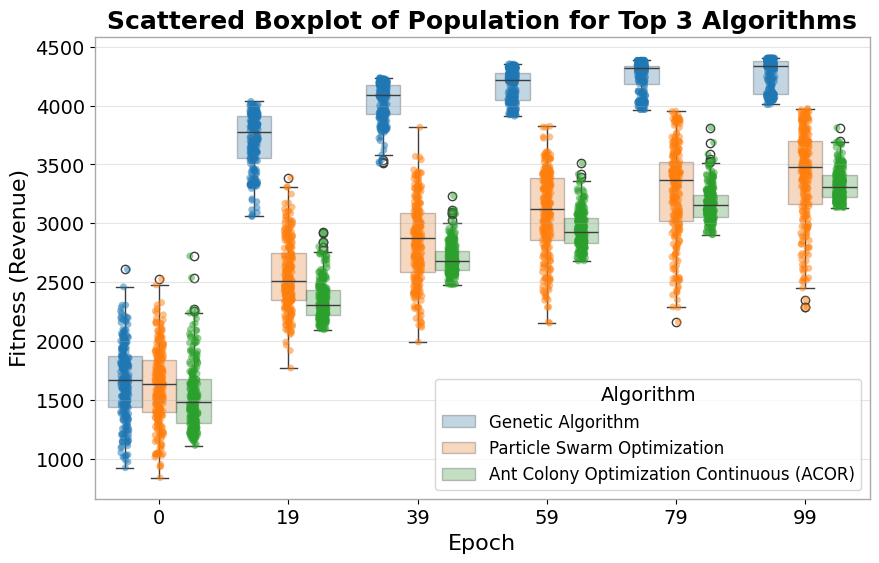

In [45]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [36]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

Algorithm  Run  Revenue  \
21                                Genetic Algorithm    2  4407.02   
22                                Genetic Algorithm    3  4397.00   
24                                Genetic Algorithm    5  4394.21   
23                                Genetic Algorithm    4  4359.11   
20                                Genetic Algorithm    1  4348.73   
35                      Particle Swarm Optimization    1  3972.60   
37                      Particle Swarm Optimization    3  3951.24   
1         Ant Colony Optimization Continuous (ACOR)    2  3812.21   
36                      Particle Swarm Optimization    2  3806.60   
39                      Particle Swarm Optimization    5  3797.09   
38                      Particle Swarm Optimization    4  3699.86   
3         Ant Colony Optimization Continuous (ACOR)    4  3697.80   
4         Ant Colony Optimization Continuous (ACOR)    5  3692.79   
0         Ant Colony Optimization Continuous (ACOR)    1  3670.42   
17                           Differential Evolution    3  3656.84   
19                           Differential Evolution    5  3609.12   
46                     Whale Optimization Algorithm    2  3592.66   
2         Ant Colony Optimization Continuous (ACOR)    3  3586.21   
8                             Artificial Bee Colony    4  3579.31   
47                     Whale Optimization Algorithm    3  3573.69   
48                     Whale Optimization Algorithm    4  3557.95   
18                           Differential Evolution    4  3546.96   
27                              Grey Wolf Optimizer    3  3544.65   
29                              Grey Wolf Optimizer    5  3535.08   
45                     Whale Optimization Algorithm    1  3523.55   
49                     Whale Optimization Algorithm    5  3523.55   
5                             Artificial Bee Colony    1  3451.19   
15                           Differential Evolution    1  3442.21   
7                             Artificial Bee Colony    3  3395.20   
9                             Artificial Bee Colony    5  3387.38   
11  Covariance Matrix Adaptation Evolution Strategy    2  3385.11   
6                             Artificial Bee Colony    2  3378.89   
12  Covariance Matrix Adaptation Evolution Strategy    3  3348.85   
14  Covariance Matrix Adaptation Evolution Strategy    5  3246.36   
10  Covariance Matrix Adaptation Evolution Strategy    1  3097.36   
13  Covariance Matrix Adaptation Evolution Strategy    4  3073.36   
16                           Differential Evolution    2  3062.25   
25                              Grey Wolf Optimizer    1  2946.60   
26                              Grey Wolf Optimizer    2  2832.62   
31  Hybrid Grey Wolf - Whale Optimization Algorithm    2  2786.66   
44                              Simulated Annealing    5  2762.54   
34  Hybrid Grey Wolf - Whale Optimization Algorithm    5  2734.24   
28                              Grey Wolf Optimizer    4  2704.17   
30  Hybrid Grey Wolf - Whale Optimization Algorithm    1  2682.90   
32  Hybrid Grey Wolf - Whale Optimization Algorithm    3  2663.62   
40                              Simulated Annealing    1  2656.66   
33  Hybrid Grey Wolf - Whale Optimization Algorithm    4  2647.82   
43                              Simulated Annealing    4  2601.35   
42                              Simulated Annealing    3  2507.06   
41                              Simulated Annealing    2  1796.63   

    Execution Time (s.)  Scheduled Trains  Delta DT (min.)  Delta TT (min.)  \
21                25.41                18             20.0             20.0   
22                25.26                18             22.0             14.0   
24                26.33                19             34.0             37.0   
23                25.01                18             27.0             26.0   
20                24.98                18             22.0             33.0   
35                25.94                17       

In [37]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU2 & RU3 \\\\\n\\midrule\n21 & Genetic Algorithm & 2 & 4407.020000 & 25.410000 & 18 & 20.000000 & 20.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n22 & Genetic Algorithm & 3 & 4397.000000 & 25.260000 & 18 & 22.000000 & 14.000000 & 50.0 % & 90.0 % & 33.33 % & 100.0 % \\\\\n24 & Genetic Algorithm & 5 & 4394.210000 & 26.330000 & 19 & 34.000000 & 37.000000 & 50.0 % & 80.0 % & 66.67 % & 100.0 % \\\\\n23 & Genetic Algorithm & 4 & 4359.110000 & 25.010000 & 18 & 27.000000 & 26.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n20 & Genetic Algorithm & 1 & 4348.730000 & 24.980000 & 18 & 22.000000 & 33.000000 & 50.0 % & 80.0 % & 50.0 % & 100.0 % \\\\\n35 & Particle Swarm Optimization & 1 & 3972.600000 & 25.940000 & 17 & 48.000000 & 92.000000 & 50.0 % & 80.0 % & 33.33 % & 100.0 % \\\\\n37 & Particle Swarm Optimization & 3 & 3951.24

In [38]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 0.7536 s.
	Execution Time (by run) - Mean: 0.1507 s. - Std: 0.0018 s.
	Revenue - Mean: 3691.8869 - Std: 80.8428
	Scheduled Trains - Mean: 18.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 2.4728 s.
	Execution Time (by run) - Mean: 0.4946 s. - Std: 0.0078 s.
	Revenue - Mean: 3438.3921 - Std: 83.7139
	Scheduled Trains - Mean: 17.0 - Std: 1.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 2.5353 s.
	Execution Time (by run) - Mean: 0.5071 s. - Std: 0.0614 s.
	Revenue - Mean: 3230.208 - Std: 141.9329
	Scheduled Trains - Mean: 15.0 - Std: 0.0
	Max Revenue: 5824.5 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 1.2516 s.
	

In [39]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

Algorithm  \
0                                Genetic Algorithm   
1                      Particle Swarm Optimization   
2        Ant Colony Optimization Continuous (ACOR)   
3                     Whale Optimization Algorithm   
4                           Differential Evolution   
5                            Artificial Bee Colony   
6  Covariance Matrix Adaptation Evolution Strategy   
7                              Grey Wolf Optimizer   
8  Hybrid Grey Wolf - Whale Optimization Algorithm   
9                              Simulated Annealing   

   Mean Execution Time (seconds)  Std Execution Time (seconds)  \
0                          25.40                          0.55   
1                          25.14                          0.48   
2                          15.11                          0.08   
3                          25.01                          0.29   
4                          25.14                          0.15   
5                          50.03                          0.26   
6                          52.13                          1.88   
7                          24.79                          0.09   
8                          24.98                          0.22   
9                          26.00                          0.27   

   Mean Fitness (revenue)  Std Fitness (revenue)  Mean Scheduled Trains  \
0                 4381.21                  25.63                     18   
1                 3845.48                 114.46                     17   
2                 3691.89                  80.84                     18   
3                 3554.28                  30.63                     15   
4                 3463.48                 238.22                     17   
5                 3438.39                  83.71                     17   
6                 3230.21                 141.93                     15   
7                 3112.63                 399.35                     16   
8                 2703.05                  56.95                     16   
9                 2464.85                 384.82                     15   

   Std Scheduled Trains  
0                     0  
1                     0  
2                     0  
3                     0  
4                     1  
5                     1  
6                     0  
7                     1  
8                     1  
9                     1

In [40]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 25.400000 & 0.550000 & 4381.210000 & 25.630000 & 18 & 0 \\\\\n1 & Particle Swarm Optimization & 25.140000 & 0.480000 & 3845.480000 & 114.460000 & 17 & 0 \\\\\n2 & Ant Colony Optimization Continuous (ACOR) & 15.110000 & 0.080000 & 3691.890000 & 80.840000 & 18 & 0 \\\\\n3 & Whale Optimization Algorithm & 25.010000 & 0.290000 & 3554.280000 & 30.630000 & 15 & 0 \\\\\n4 & Differential Evolution & 25.140000 & 0.150000 & 3463.480000 & 238.220000 & 17 & 1 \\\\\n5 & Artificial Bee Colony & 50.030000 & 0.260000 & 3438.390000 & 83.710000 & 17 & 1 \\\\\n6 & Covariance Matrix Adaptation Evolution Strategy & 52.130000 & 1.880000 & 3230.210000 & 141.930000 & 15 & 0 \\\\\n7 & Grey Wolf Optimizer & 24.790000 & 0.090000 & 3112.630000 & 399.350000 & 16 & 1

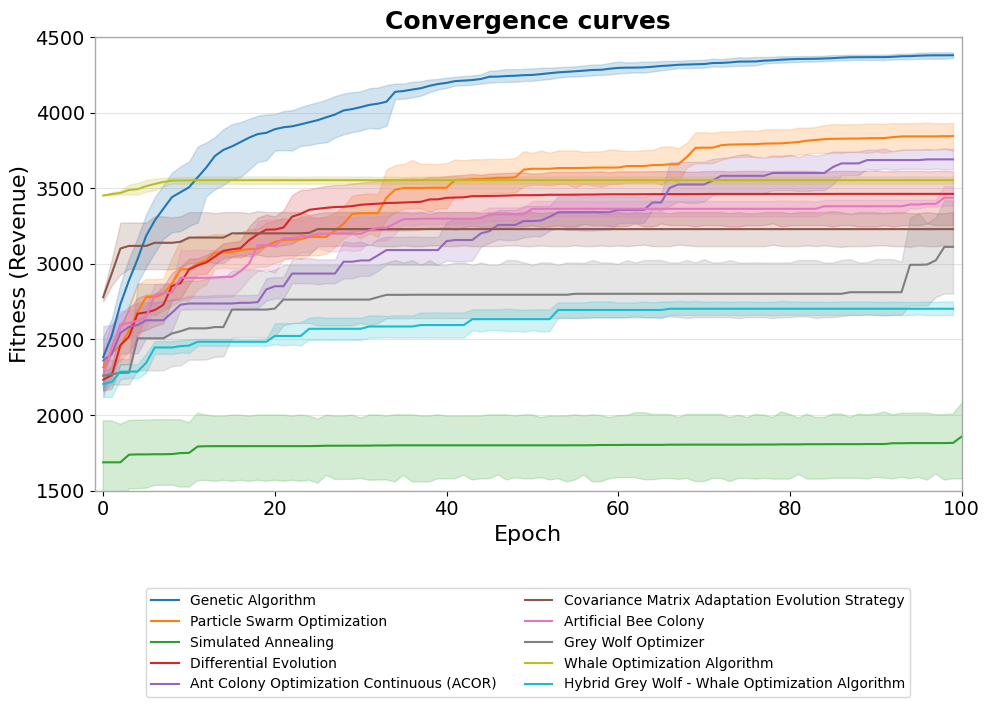

In [33]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1500,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed.pdf'),
              fig_size=(10, 9))

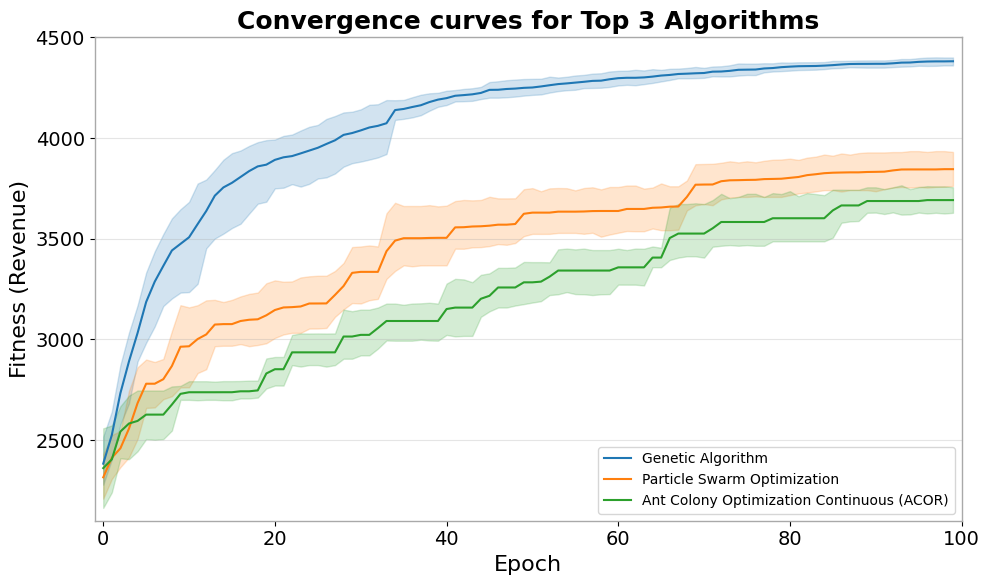

In [52]:
top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves for Top 3 Algorithms",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(2100,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed_top_3.pdf'),
              fig_size=(10, 7))

In [84]:
df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2459.878405       0.246457   
1    1  Genetic Algorithm          1  2460.308339       0.243454   
2    1  Genetic Algorithm          2  2574.487027       0.243266   
3    1  Genetic Algorithm          3  2926.528932       0.239713   
4    1  Genetic Algorithm          4  3015.854710       0.239389   

                                            Discrete  \
0  [False, True, False, True, True, True, True, F...   
1  [False, True, False, True, True, True, True, F...   
2  [False, True, False, True, True, True, True, F...   
3  [False, True, False, True, True, True, True, F...   
4  [False, True, False, True, True, False, True, ...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...   3.209825      0.000000   
1  [1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...   2.827368     11.915173   
2  [1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...   2.692281     16.123743   
3  [1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...   2.463509     23.250984   
4  [1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...   2.223509     30.728028   

   Exploration  
0   100.000000  
1    88.084827  
2    83.876257  
3    76.749016  
4    69.271972

In [99]:
algo_1_vals = df_history[df_history['Algo'] == 'Genetic Algorithm'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(list).sum()

algo_1_vals

[2459.8784050540485,
 2460.3083388679565,
 2574.4870272813346,
 2926.5289315927625,
 3015.8547096467346,
 3344.275751866224,
 3344.275751866224,
 3444.320288655691,
 3557.587126334182,
 3609.386675464446,
 3651.756526224598,
 3717.519570123164,
 3717.519570123164,
 3777.613188465174,
 3788.2007221491294,
 3795.1263325982354,
 3886.130792439707,
 3886.130792439707,
 3886.130792439707,
 3886.130792439707,
 3886.130792439707,
 3886.130792439707,
 3886.130792439707,
 3890.6147094998714,
 3894.1036804958712,
 3907.136872718911,
 3917.7650679444014,
 3924.248078063747,
 4022.1707270412007,
 4037.122743652392,
 4044.709553399591,
 4045.912338713199,
 4061.8600568595866,
 4073.018417118089,
 4076.3384134207,
 4085.817405378902,
 4090.91745902702,
 4098.514710261112,
 4119.496634906351,
 4154.276327501203,
 4154.276327501203,
 4170.162384335007,
 4172.749779186623,
 4181.419161330111,
 4191.30465137983,
 4198.087739546772,
 4198.087739546772,
 4198.088857193829,
 4203.320224299677,
 4209.888824

In [100]:
len(algo_1_vals)

500

In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [103]:
len(algo_1_vals)

500

In [127]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals
    
matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_last_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_last_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [128]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                  172.0   
Simulated Annealing                                            0.0   
Differential Evolution                                        59.0   
Ant Colony Optimization Continuous (ACOR)                     29.0   
Covariance Matrix Adaptation Evolution Strategy              970.0   
Artificial Bee Colony                                         63.0   
Grey Wolf Optimizer                                            1.0   
Whale Optimization Algorithm                                9918.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      172.0   
Particle Swarm Optimization                          

In [129]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

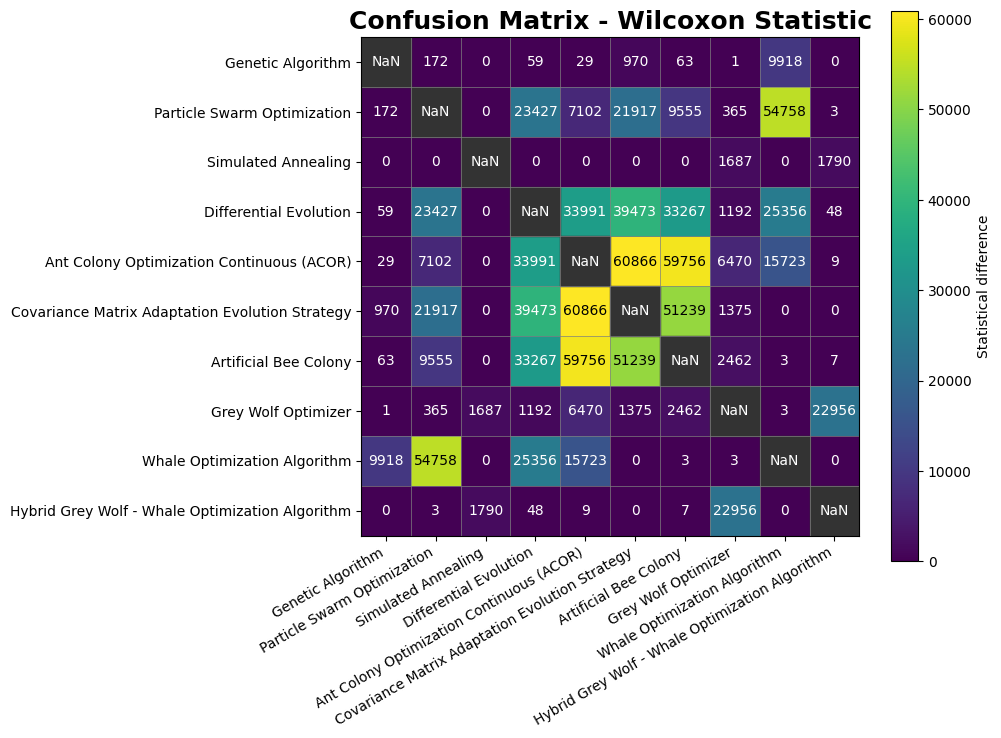

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [125]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat